In [2]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# Analysis

## Data PReparation

In [3]:
mode1 = 'nh'
iout1 = 1026
repo, rurmode, dp = mode2repo(mode1)
nh1 = uri.RamsesSnapshot(repo, iout1, mode=rurmode)
nhs1 = uri.TimeSeries(nh1)
nhs1.read_iout_avail()
nout1 = nhs1.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(nh1, galaxy=True, double_precision=dp)
hals1 = uhmi.HaloMaker.load(nh1, galaxy=False, double_precision=dp)
database1 = f"/home/jeon/MissingSat/database"
LG1 = pklload(f"{database1}/LG")
keys1 = []
for key in LG1.keys():
    if(LG1[key]['isLG']): keys1.append(key)
keys1 = np.array(keys1)

mode2 = 'nh2'
iout2 = 797
repo, rurmode, dp = mode2repo(mode2)
nh2 = uri.RamsesSnapshot(repo, iout2, mode=rurmode)
nhs2 = uri.TimeSeries(nh2)
nhs2.read_iout_avail()
nout2 = nhs2.iout_avail['iout']
gals2 = uhmi.HaloMaker.load(nh2, galaxy=True, double_precision=dp)
hals2 = uhmi.HaloMaker.load(nh2, galaxy=False, double_precision=dp)
database2 = f"/home/jeon/MissingSat/database/nh2"
LG2 = pklload(f"{database2}/LG")
keys2 = []
for key in LG2.keys():
    if(LG2[key]['isLG']): keys2.append(key)
keys2 = np.array(keys2)

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


In [4]:
allsubs1 = None
states1 = None
for key in LG1.keys():
    subs = LG1[key]['subs']
    assert (subs['Host'] == key).all()
    real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    dink_ind = isin(subs['id'], dink)
    subs['dink'][dink_ind] = True
    subs['dink'][~dink_ind] = False

    state = np.zeros(len(subs), dtype='<U7')
    state[dink_ind] = 'dink'
    state[~dink_ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    u_ind = isin(subs['id'], upair)
    state[u_ind] = 'upair'

    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
    # if(key==1): print(subs[state=='dink']['id'])
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
LGmask1 = isin(allsubs1['Host'], keys1)
# allsubs1 = allsubs1[LGmask1]; states1 = states1[LGmask1]
len(allsubs1)

3851

In [5]:
allsubs2 = None
states2 = None
for key in LG2.keys():
    subs = LG2[key]['subs']
    assert (subs['Host'] == key).all()
    real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    dink_ind = isin(subs['id'], dink)
    subs['dink'][dink_ind] = True
    subs['dink'][~dink_ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[dink_ind] = 'dink'
    state[~dink_ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    u_ind = isin(subs['id'], upair)
    state[u_ind] = 'upair'

    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
LGmask2 = isin(allsubs2['Host'], keys2)
# allsubs2 = allsubs2[LGmask2]; states2 = states2[LGmask2]
len(allsubs2)


1242

In [6]:
subs1 = None; dinks1 = None; pairs1 = None; upairs1 = None
for key in keys1:
    tmp = LG1[key]['subs']
    subs1 = tmp if(subs1 is None) else np.hstack((subs1, tmp))

    real = LG1[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks1 = tmp1 if(dinks1 is None) else np.hstack((dinks1, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs1 = tmp1 if(pairs1 is None) else np.hstack((pairs1, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs1 = tmp1 if(upairs1 is None) else np.hstack((upairs1, tmp1))
print(len(subs1), len(dinks1), len(pairs1), len(upairs1))

subs2 = None; dinks2 = None; pairs2 = None; upairs2 = None
for key in keys2:
    tmp = LG2[key]['subs']
    subs2 = tmp if(subs2 is None) else np.hstack((subs2, tmp))

    real = LG2[key]['real']

    dink_hids = real[real['state'] == 'dink']['hid']
    tmp1 = tmp[isin(tmp['id'], dink_hids)]
    if(len(tmp1)>0):
        dinks2 = tmp1 if(dinks2 is None) else np.hstack((dinks2, tmp1))
    pair_hids = real[real['state'] == 'pair']['hid']
    tmp1 = tmp[isin(tmp['id'], pair_hids)]
    if(len(tmp1)>0):
        pairs2 = tmp1 if(pairs2 is None) else np.hstack((pairs2, tmp1))
    upair_hids = real[real['state'] == 'upair']['hid']
    tmp1 = tmp[isin(tmp['id'], upair_hids)]
    if(len(tmp1)>0):
        upairs2 = tmp1 if(upairs2 is None) else np.hstack((upairs2, tmp1))
print(len(subs2), len(dinks2), len(pairs2), len(upairs2))

1336 1145 130 61
1242 1120 79 43


# Function

In [7]:
def draw_analysis(yvalue, fname, yerrs=None,ymask=None, xname='mvir', ylabel='value', legkwargs={}, ylim=None):
    global allsubs1, states1, dinks1, pairs1, LGmask1
    global allsubs2, states2, dinks2, pairs2, LGmask2

    allsubs = np.hstack((allsubs1,allsubs2))
    states = np.hstack((states1,states2))
    LGmask = np.hstack((LGmask1,LGmask2))
    dinks = np.hstack((dinks1, dinks2))
    pairs = np.hstack((pairs1, pairs2))
    m1d, m2d = np.nanpercentile(dinks[xname], q=[2.5,97.5])
    m1p, m2p = np.nanpercentile(pairs[xname], q=[2.5,97.5])
    m1 = np.max([m1d,m1p]); m2 = np.min([m2d,m2p])

    mbins = np.linspace(7,12,9)
    mleng = len(mbins)-1
    xs = 0.5*(mbins[1:]+mbins[:-1])
    colors = ['k', 'r', 'b', 'g']
    

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8), dpi=150, sharey='row', sharex='col', gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 4]})
    AX = axes[1,0]
    ax_right = axes[1,1]
    ax_top = axes[0,0]
    ax_top.set_ylabel("Normed Den.")

    # Dink
    # -------------------------------------------------------------------------
    color='tomato'
    mask = states=='dink'
    if(ymask is not None): mask = mask & ymask
    if(len(yvalue) != len(allsubs)):
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]
    else:
        sample = allsubs[mask & LGmask]
        val = yvalue[mask & LGmask]
        if(yerrs is not None): err = yerrs[mask & LGmask]

    if(yerrs is None): AX.scatter(np.log10(sample[xname]), val, s=5, ec=color,fc='none', label='Starless', marker='s')
    else: AX.errorbar(np.log10(sample[xname]), val, yerr=err, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Starless')
    colorcount=1
    ys = np.zeros(mleng)-1; y16s = np.zeros(mleng)-1; y84s = np.zeros(mleng)-1
    for i in range(mleng):
        mask = (sample[xname] >= 10**mbins[i])&(sample[xname] < 10**mbins[i+1])
        if(np.sum(mask)>3):
            value = val[mask]
            y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
        else:
            y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
    mask = ~np.isnan(ys)
    AX.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
    AX.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
    colorcount+=1
    complete = (sample[xname] >= m1)&(sample[xname] <= m2)
    ax_right.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step', density=True)
    q16,q50,q84 = np.nanpercentile(val[complete], q=[16,50,84])
    ax_right.axhline(q50, color=colors[1], label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
    ax_right.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
    ax_top.hist(np.log10(sample[xname]), bins=20, color=color, histtype='step', density=True)

    # Pair
    # -------------------------------------------------------------------------
    color='dodgerblue'
    mask = states=='pair'
    if(ymask is not None): mask = mask & ymask
    if(len(yvalue) != len(allsubs)):
        sample = allsubs[mask]
        val = yvalue[mask]
        if(yerrs is not None): err = yerrs[mask]
    else:
        sample = allsubs[mask & LGmask]
        val = yvalue[mask & LGmask]
        if(yerrs is not None): err = yerrs[mask & LGmask]

    if(yerrs is None): AX.scatter(np.log10(sample[xname]), val, s=5, ec=color,fc='none', label='Pair', marker='s')
    else: AX.errorbar(np.log10(sample[xname]), val, yerr=err, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
    ys = np.zeros(mleng)-1; y16s = np.zeros(mleng)-1; y84s = np.zeros(mleng)-1
    for i in range(mleng):
        mask = (sample[xname] >= 10**mbins[i])&(sample[xname] < 10**mbins[i+1])
        if(np.sum(mask)>3):
            value = val[mask]
            y16s[i], ys[i], y84s[i] = np.nanpercentile(value, q=[16,50,84])
        else:
            y16s[i], ys[i], y84s[i] = np.nan,np.nan,np.nan
    mask = ~np.isnan(ys)
    AX.fill_between(xs[mask], y16s[mask], y84s[mask], fc=colors[colorcount], ec='none', alpha=0.2, zorder=5)
    AX.plot(xs[mask], ys[mask], color=colors[colorcount], zorder=6)
    colorcount+=1
    complete = (sample[xname] >= m1)&(sample[xname] <= m2)
    ax_right.hist(val[complete], bins=20, orientation='horizontal', color=color, histtype='step', density=True)
    q16,q50,q84 = np.nanpercentile(val[complete], q=[16,50,84])
    ax_right.axhline(q50, color=colors[2], label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
    ax_right.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)
    ax_top.hist(np.log10(sample[xname]), bins=20, color=color, histtype='step', density=True)


    AX.legend()
    ax_right.legend(**legkwargs)

    AX.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
    ax_top.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
    ax_right.set_facecolor('gainsboro')
    ax_top.text((np.log10(m1)+np.log10(m2))/2, ax_top.get_ylim()[1]*0.9, '"Complete"\nrange', ha='center', va='top', color='k', fontsize=8, family='serif')
    if(xname=='mvir'): AX.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
    elif(xname=='mdm_vir'): AX.set_xlabel(r'logM$_{\rm DM,vir}$ [M$_\odot$]')
    AX.set_ylabel(ylabel)
    ax_right.set_xlabel(r'Normed Den.')
    ax_right.set_xlim(0.001,)
    if(ylim is not None): AX.set_ylim(*ylim)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(fname, dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
    plt.show(); plt.close()

## Stellar Fraction

In [8]:
allsubs1.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

/tmp/ipykernel_15512/1325373136.py:11: RuntimeWarning: divide by zero encountered in log10
  yvalue = np.log10(yvalue)


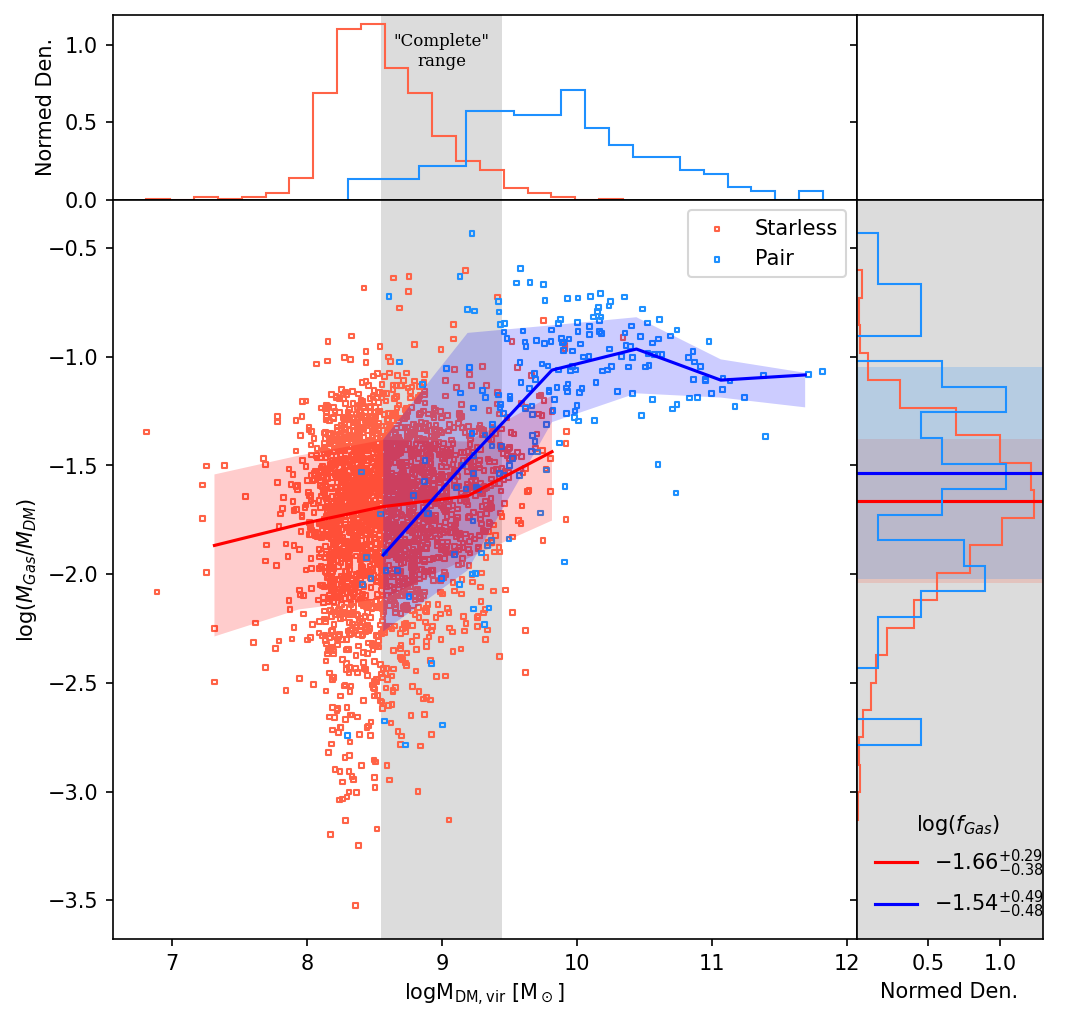

In [12]:
ylabel = r'log$(M_{Gas}/M_{DM})$ '
legtitle = r'log$(f_{Gas})$ '
legkwargs = dict(title=legtitle, frameon=False)
ylim = None

sample = np.hstack((allsubs1,allsubs2 ))
yvalue = sample['mcell_vir'] / (sample['mdm_vir']+sample['mstar_vir']+sample['mcell_vir'])
ymask = yvalue>0
# yvalue[yvalue==0] = 10**(-6.5)
# ymask = None
yvalue = np.log10(yvalue)
fname = f"04_fcell.png"
draw_analysis(yvalue, fname, ymask=ymask, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

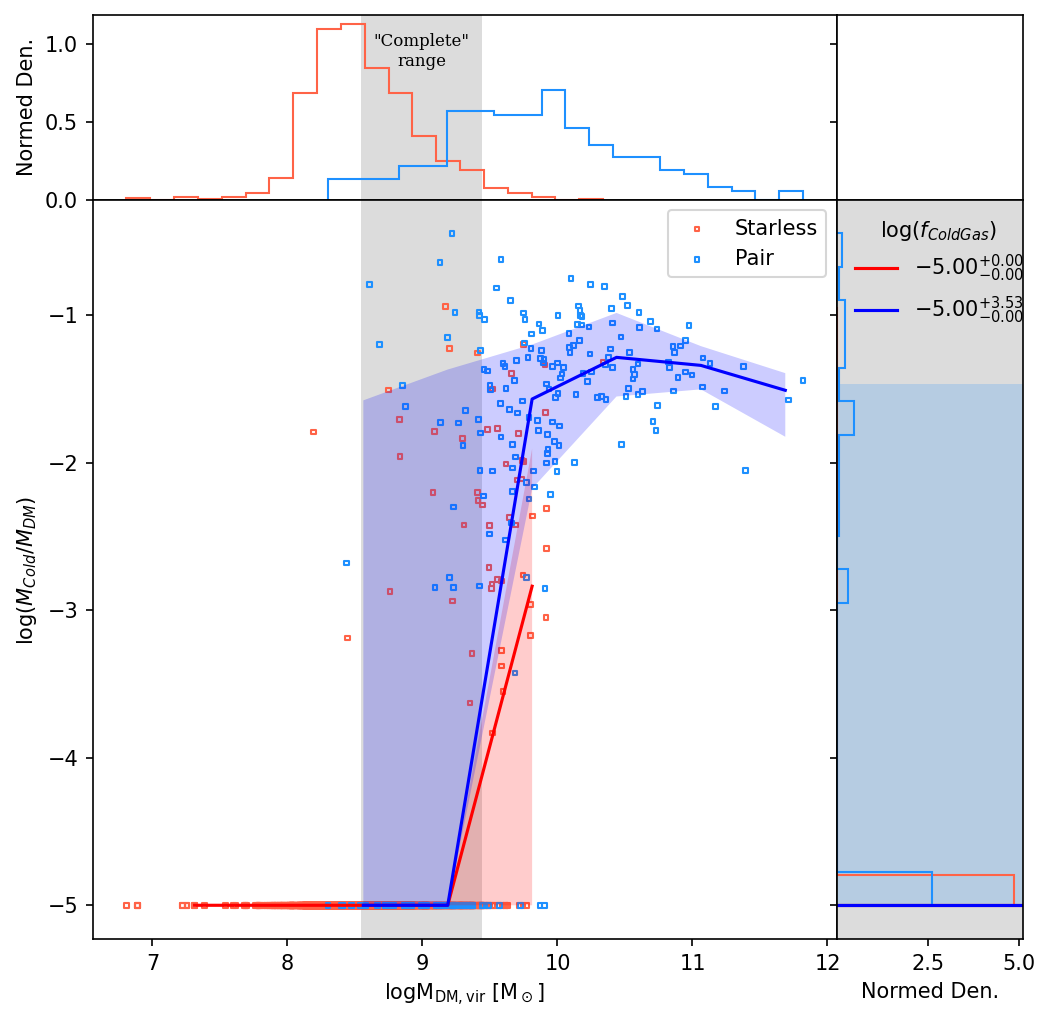

In [13]:
ylabel = r'log$(M_{Cold}/M_{DM})$ '
legtitle = r'log$(f_{ColdGas})$ '
legkwargs = dict(title=legtitle, frameon=False)
ylim = None

sample = np.hstack((allsubs1,allsubs2 ))
yvalue = sample['mcold_vir'] / (sample['mdm_vir']+sample['mstar_vir']+sample['mcell_vir'])
yvalue[yvalue==0] = 10**(-5)
# ymask = yvalue>0
# yvalue[yvalue==0] = 10**(-6.5)
ymask = None
yvalue = np.log10(yvalue)
fname = f"04_fcold.png"
draw_analysis(yvalue, fname, ymask=ymask, xname='mdm_vir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

## Environments?

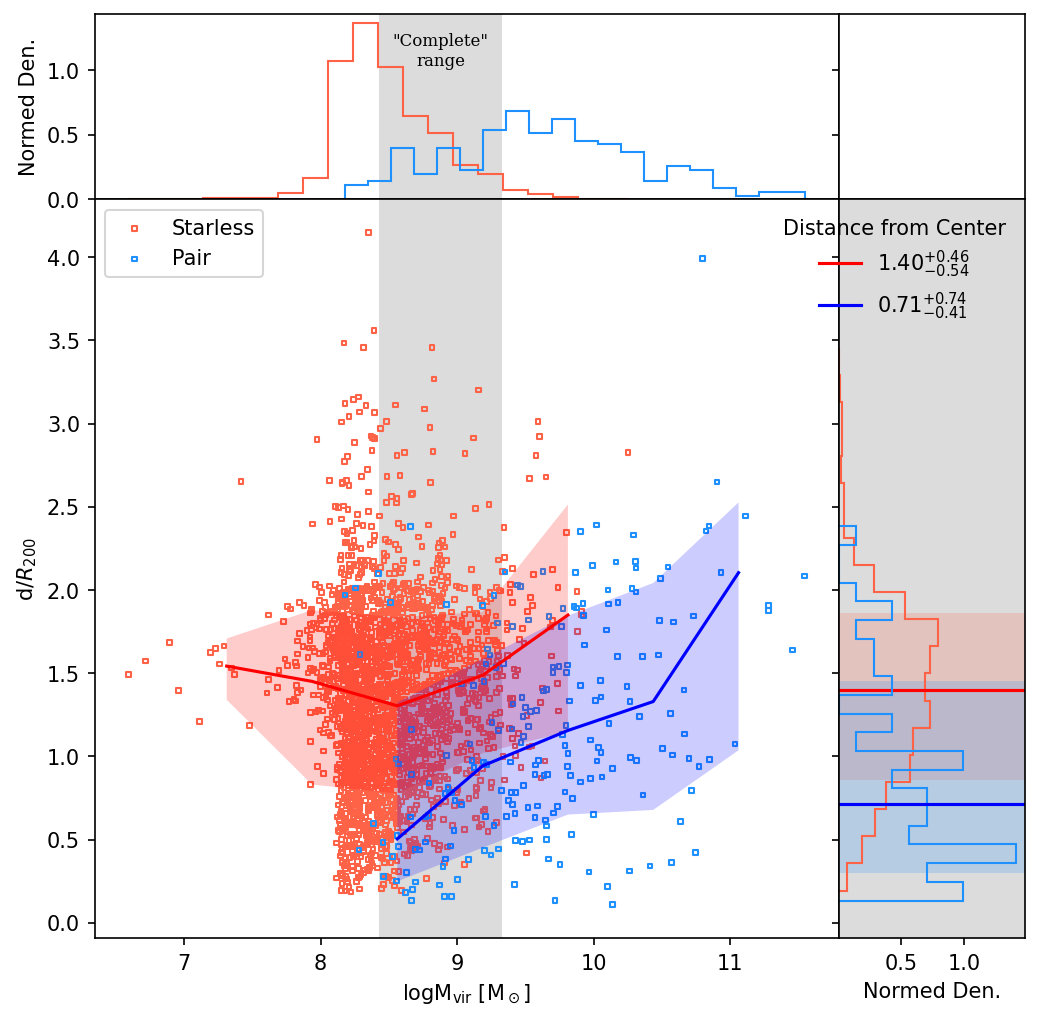

In [15]:
ylabel = r'd/$R_{200}$'
legtitle = r'Distance from Center'
legkwargs = dict(title=legtitle, frameon=False)
ylim = None


yvalue1 = np.zeros(len(allsubs1))
for i in range(len(allsubs1)):
    if(LGmask1[i]):
        BGG = LG1[allsubs1[i]['Host']]['BGG']
        yvalue1[i] = distance(allsubs1[i], BGG)/BGG['r200_code']
yvalue2 = np.zeros(len(allsubs2))
for i in range(len(allsubs2)):
    if(LGmask2[i]):
        BGG = LG2[allsubs2[i]['Host']]['BGG']
        yvalue2[i] = distance(allsubs2[i], BGG)/BGG['r200_code']
yvalue = np.hstack((yvalue1, yvalue2))
# ymask = yvalue>0
# yvalue[yvalue==0] = 10**(-5)
ymask = None
# yvalue = np.log10(yvalue)
fname = f"04_env.png"
draw_analysis(yvalue, fname,ymask=ymask, xname='mvir', ylabel=ylabel, legkwargs=legkwargs, ylim=ylim)

## Mass Histogram

/tmp/ipykernel_1889/2636435991.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(y)}" for y in ytick])
/tmp/ipykernel_1889/2636435991.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(y)}" for y in ytick])


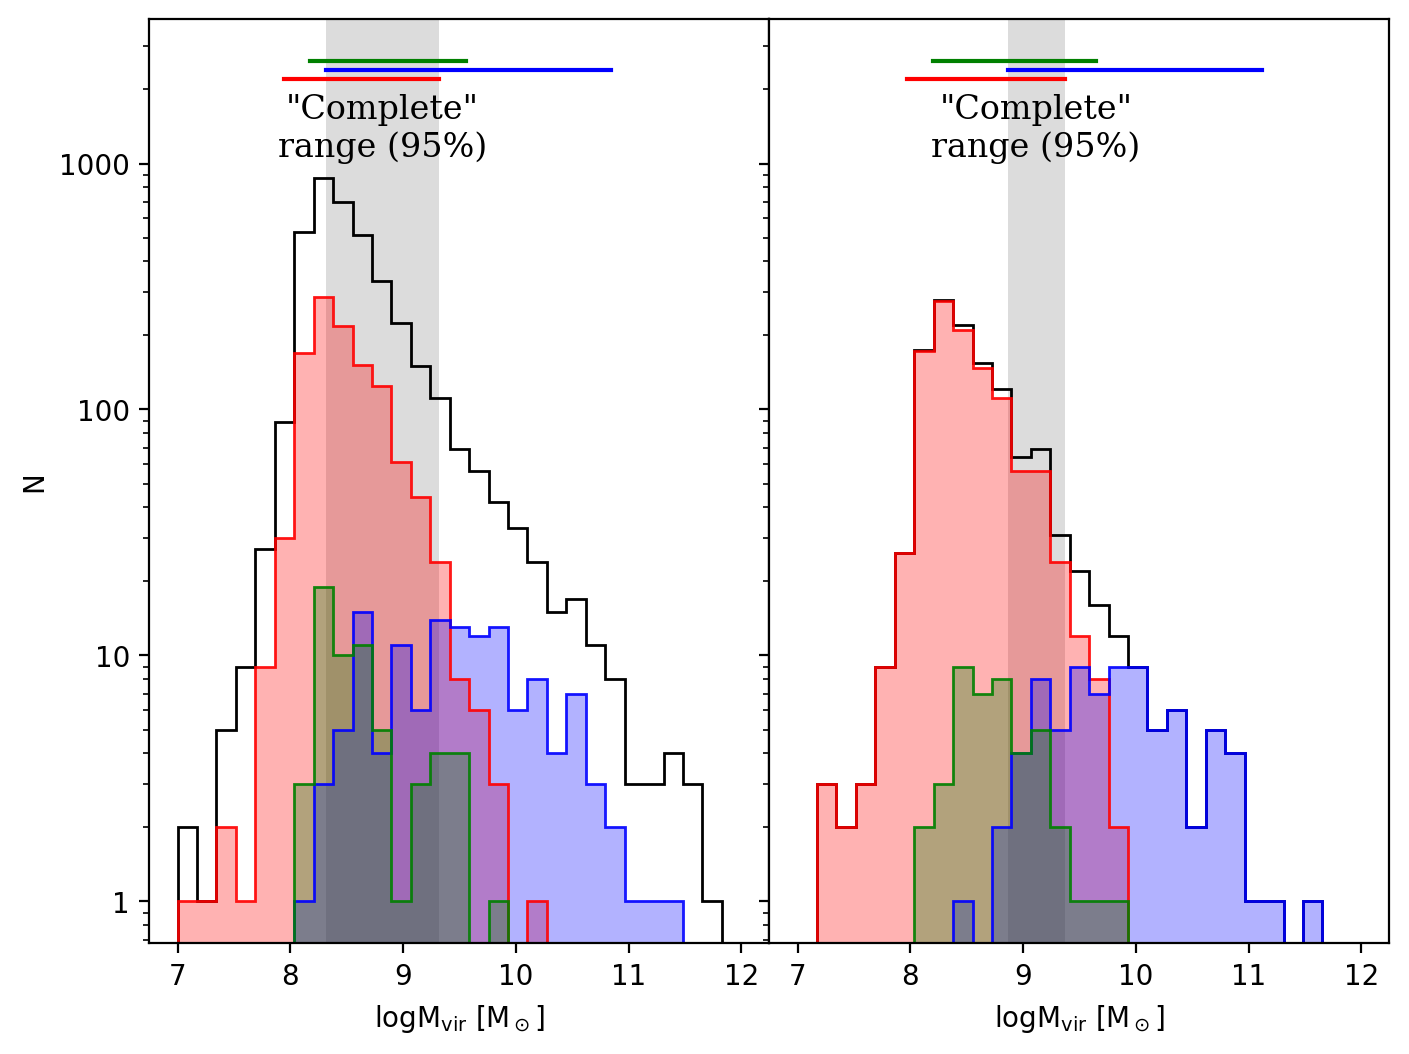

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=200, sharey=True)
plt.subplots_adjust(wspace=0)

mbins = np.linspace(7,12,30)
mleng = len(mbins)-1
xs = 0.5*(mbins[1:]+mbins[:-1])
colors = ['k', 'r', 'b', 'g']

ax = axes[0]
m1d, m2d = np.nanpercentile(dinks1['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs1['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs1['mvir'], q=[2.5,97.5])
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])

colorcount = 0
ax.hist(np.log10(allsubs1['mvir']), bins=mbins, color=colors[colorcount],label='All', histtype='step'); colorcount+=1
ax.plot([np.log10(m1d), np.log10(m2d)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(dinks1['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(dinks1['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='step', alpha=0.9); colorcount+=1
ax.plot([np.log10(m1p), np.log10(m2p)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(pairs1['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(pairs1['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='step', alpha=0.9); colorcount+=1
ax.plot([np.log10(m1u), np.log10(m2u)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(upairs1['mvir']), bins=mbins, color=colors[colorcount],label='UDG-like', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(upairs1['mvir']), bins=mbins, color=colors[colorcount],label='UDG-like', histtype='step', alpha=0.9); colorcount+=1
ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax.text((np.log10(m1)+np.log10(m2))/2, 1000, '"Complete"\nrange (95%)', ha='center', va='bottom', color='k', fontsize=12, family='serif')
ax.set_yscale('log')
ytick = ax.get_yticks()
ax.set_yticklabels([f"{int(y)}" for y in ytick])
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'N')

ax = axes[1]
m1d, m2d = np.nanpercentile(dinks2['mvir'], q=[2.5,97.5])
m1p, m2p = np.nanpercentile(pairs2['mvir'], q=[2.5,97.5])
m1u, m2u = np.nanpercentile(upairs2['mvir'], q=[2.5,97.5])
m1 = np.max([m1d,m1p,m1u]); m2 = np.min([m2d,m2p,m2u])

colorcount = 0
ax.hist(np.log10(allsubs2['mvir']), bins=mbins, color=colors[colorcount],label='All', histtype='step'); colorcount+=1
ax.plot([np.log10(m1d), np.log10(m2d)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(dinks2['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(dinks2['mvir']), bins=mbins, color=colors[colorcount],label='Starless', histtype='step', alpha=0.9); colorcount+=1
ax.plot([np.log10(m1p), np.log10(m2p)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(pairs2['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(pairs2['mvir']), bins=mbins, color=colors[colorcount],label='Pair', histtype='step', alpha=0.9); colorcount+=1
ax.plot([np.log10(m1u), np.log10(m2u)], [2000*(1+colorcount/10),2000*(1+colorcount/10)], color=colors[colorcount])
ax.hist(np.log10(upairs2['mvir']), bins=mbins, color=colors[colorcount],label='UDG-like', histtype='stepfilled', alpha=0.3)
ax.hist(np.log10(upairs2['mvir']), bins=mbins, color=colors[colorcount],label='UDG-like', histtype='step', alpha=0.9); colorcount+=1
ax.axvspan(np.log10(m1), np.log10(m2), ec='none', fc='gainsboro', zorder=-1)
ax.text((np.log10(m1)+np.log10(m2))/2, 1000, '"Complete"\nrange (95%)', ha='center', va='bottom', color='k', fontsize=12, family='serif')
ax.set_yscale('log')
ytick = ax.get_yticks()
ax.set_yticklabels([f"{int(y)}" for y in ytick])
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
plt.savefig("04_NumberMass.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

In [55]:
nhs1.iout_avail[nhs1.iout_avail['age'] >= nh1.age-1]

array([( 899, 0.78872322, 10.63173419, 28601, -0.28558631),
       ( 900, 0.78888188, 10.63420623, 28604, -0.28529984),
       ( 901, 0.78983015, 10.64890718, 28623, -0.28359846),
       ( 902, 0.79080055, 10.6639479 , 28642, -0.28186208),
       ( 903, 0.79090009, 10.66549229, 28644, -0.28168397),
       ( 904, 0.79179463, 10.67939357, 28662, -0.28008332),
       ( 905, 0.79275002, 10.69419558, 28682, -0.27838284),
       ( 906, 0.79360061, 10.7073558 , 28700, -0.27687448),
       ( 907, 0.79360747, 10.70746214, 28797, -0.2768623 ),
       ( 908, 0.79369782, 10.70886145, 28799, -0.27670208),
       ( 909, 0.79446611, 10.72077486, 28817, -0.27533967),
       ( 910, 0.79467923, 10.7240843 , 28822, -0.27496174),
       ( 911, 0.79540242, 10.73530009, 28839, -0.27368223),
       ( 912, 0.79566234, 10.73930901, 28845, -0.27322545),
       ( 913, 0.79650023, 10.75225034, 28864, -0.27175295),
       ( 914, 0.79662738, 10.75421614, 28867, -0.27152949),
       ( 915, 0.79743806, 10.76676772, 2

In [56]:
1/0.78872322 - 1

0.267871890471286

In [57]:
1/0.85361393 - 1

0.17148978578641527